# Импорт библиотек

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from google.colab import files
from google.colab import drive

# Загрузка данных

In [25]:
# Подключение гугл диска
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Ссылка на файл из гугл диска
file_path = '/content/drive/MyDrive/kw_cleared_dataset.csv'

In [27]:
# Загружаем данные с разделителем
df = pd.read_csv(file_path, sep=';')

In [28]:
# Общая информация о данных
print("Общая информация о данных:")
print(df.info())

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499800 entries, 0 to 499799
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   indx          499800 non-null  int64 
 1   rating_int    499800 non-null  int64 
 2   rubrics_list  499800 non-null  object
 3   cleared_text  499800 non-null  object
 4   key_words     499800 non-null  object
dtypes: int64(2), object(3)
memory usage: 19.1+ MB
None


In [29]:
# Первые несколько строк
print("Первые несколько строк:")
df.head()

Первые несколько строк:


,indx,rating_int,rubrics_list,cleared_text,key_words
0,0,3,['жилой комплекс'],Московский квартал два. Шумно летом по ноча...,"['московская квартира', 'урбанизм', 'читальный..."
1,1,5,"['магазин продуктов', 'продукты глубокой замор...","Замечательная сеть магазинов в общем, хороший ...","['интернет-магазины', 'интернет-маркетинг']"
2,2,1,['фитнес клуб'],"Не знаю смутят ли кого то данные правила, но я...",['юла']
3,3,4,"['пункт проката', 'прокат велосипедов', 'сапсё...",Хорошие условия аренды. Дружелюбный персонал...,['сноуборд']
4,4,5,"['салон красоты', 'визажисты', 'стилисты', 'са...",Топ мастер Ангелина топ во всех смыслах Немн...,"['эльдорадо', 'читальный зал', 'визуализация д..."


In [30]:
# Проверка количества пропущенных значений в столбце 'cleared_text'
print("Количество пропущенных значений в столбце 'cleared_text':", df['cleared_text'].isna().sum())

Количество пропущенных значений в столбце 'cleared_text': 0


# Баланс классов

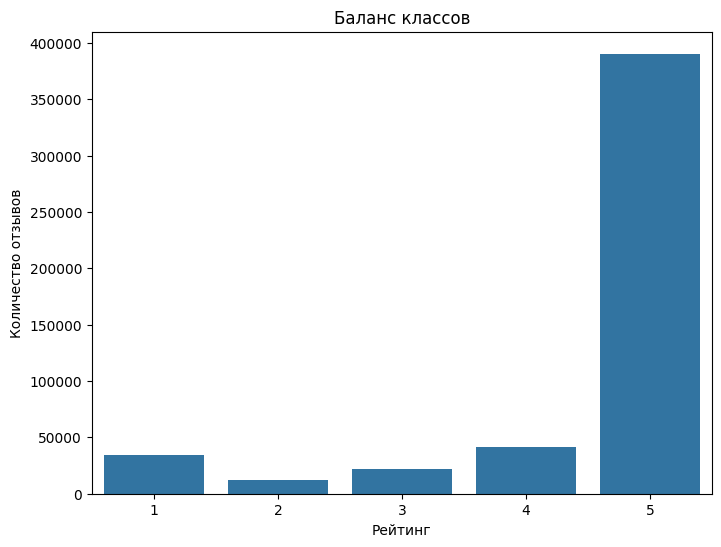

In [42]:
# Баланс классов для рейтинга
plt.figure(figsize=(8, 6))
sns.countplot(x='rating_int', data=df)
plt.title('Баланс классов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество отзывов')
plt.show()

**Вывод:**
Наблюдается сильный дисбаланс классов. Большинство отзывов с рейтингом 5. Это может значить, что модель будет более успешно генерировать рейтинг для отзывов с рейтингом 5, нежели с рейтингом 2

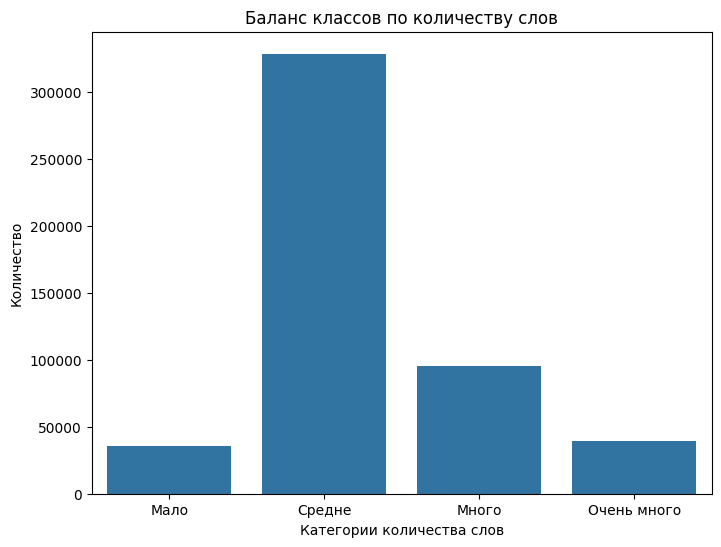

In [43]:
# Баланс классов по количеству слов в отзыве
# Подсчёт количества слов
df['word_count'] = df['cleared_text'].apply(lambda x: len(x.split()))

# Категории по количеству слов
df['word_count_category'] = pd.cut(df['word_count'], bins=[0, 10, 50, 100, np.inf],
                                   labels=['Мало', 'Средне', 'Много', 'Очень много'])

plt.figure(figsize=(8, 6))
sns.countplot(x='word_count_category', data=df)
plt.title('Баланс классов по количеству слов')
plt.xlabel('Категории количества слов')
plt.ylabel('Количество')
plt.show()

**Вывод:** Большинство отзывов имеют от 10 до 50 слов.

# Распределение длин объектов из выборки

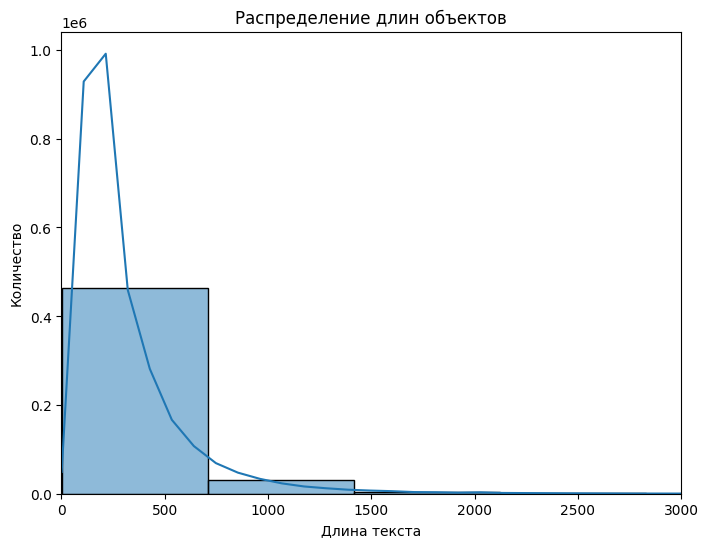

In [49]:
df['text_length'] = df['cleared_text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.xlim(0, 3000)
plt.title('Распределение длин объектов')
plt.xlabel('Длина текста')
plt.ylabel('Количество')
plt.show()

**Вывод:** Большинство текстов имеют небольшую длину (находятся в диапазоне до 500 символов). Можно удалять длинные тексты (например, в которых содержится более 5000 символов)

# Распределение длин слов объектов из выборки

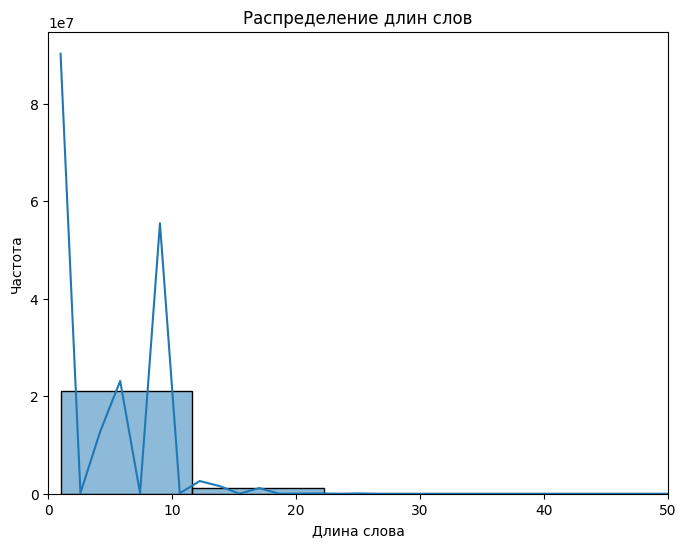

In [50]:
def word_lengths(text):
    words = text.split()
    return [len(word) for word in words]

all_word_lengths = df['cleared_text'].apply(word_lengths)
all_word_lengths_flat = [item for sublist in all_word_lengths for item in sublist]

plt.figure(figsize=(8, 6))
sns.histplot(all_word_lengths_flat, bins=30, kde=True)
plt.xlim(0, 50)
plt.title('Распределение длин слов')
plt.xlabel('Длина слова')
plt.ylabel('Частота')
plt.show()

**Вывод:** Большинство слов имеют длину от 1 до 10 символов, это ожидаемо для текстовых данных на естественном языке, где короткие слова (например, предлоги, союзы и частицы) встречаются чаще всего.

# Количество уникальных слов

In [61]:
def clean_text(text):
    text = re.sub(r'[.,!?;:\-]', ' ', text)  # Удаляем знаки препинания
    words = re.findall(r'\b\w+\b', text.lower())  # Разбиваем текст на слова
    return [word for word in words]

all_words = df['cleared_text'].apply(clean_text)
all_words_flat = [item for sublist in all_words for item in sublist]
unique_words = set(all_words_flat)
print(f'Количество уникальных слов: {len(unique_words)}')

Количество уникальных слов: 375917


In [68]:
def clean_text(text):
    # Удаляем предлоги, союзы
    stopwords = {
        'вокруг', 'около', 'к', 'в', 'на', 'из-за', 'перед', 'под', 'через', 'до', 'с', 'вследствие', 'по', 'ввиду',
        'от', 'ради', 'для', 'без', 'вопреки', 'несмотря на', 'насчёт', 'о', 'об', 'про', 'да', 'ни-ни', 'тоже',
        'также', 'а', 'но', 'зато', 'однако', 'же', 'или', 'либо', 'то-то', 'то ли', 'не то', 'как', 'чтобы', 'что',
        'будто', 'когда', 'как только', 'между тем как', 'лишь', 'лишь только', 'едва лишь', 'пока', 'ибо', 'не', 'за', 'это', 'то', 'из',
        'потому что', 'оттого что', 'так как', 'из-за того что', 'благодаря тому что', 'вследствие того что', 'так',
        'в связи с тем что', 'чтобы', 'чтоб', 'дабы', 'для того чтобы', 'с тем чтобы', 'если', 'если бы', 'ежели',
        'ежели бы', 'коли', 'раз', 'хотя', 'хоть', 'хотя бы', 'пусть', 'даром что', 'несмотря на то что', 'у',
        'невзирая на то что', 'как бы', 'как будто', 'будто бы', 'словно', 'словно как', 'точно', 'так что', 'и'
    }
    text = re.sub(r'[.,!?;:\-]', ' ', text)  # Удаляем знаки препинания
    words = re.findall(r'\b\w+\b', text.lower())  # Разбиваем текст на слова
    return [word for word in words if word not in stopwords]

all_words_cleaned = df['cleared_text'].apply(clean_text)
all_words_cleaned_flat = [item for sublist in all_words_cleaned for item in sublist]
unique_words = set(all_words_cleaned_flat)
print(f'Количество уникальных слов (без предлогов и знаков препинания): {len(unique_words)}')

Количество уникальных слов (без предлогов и знаков препинания): 375859


# ТОП самых часто встречающихся слов и словосочетаний

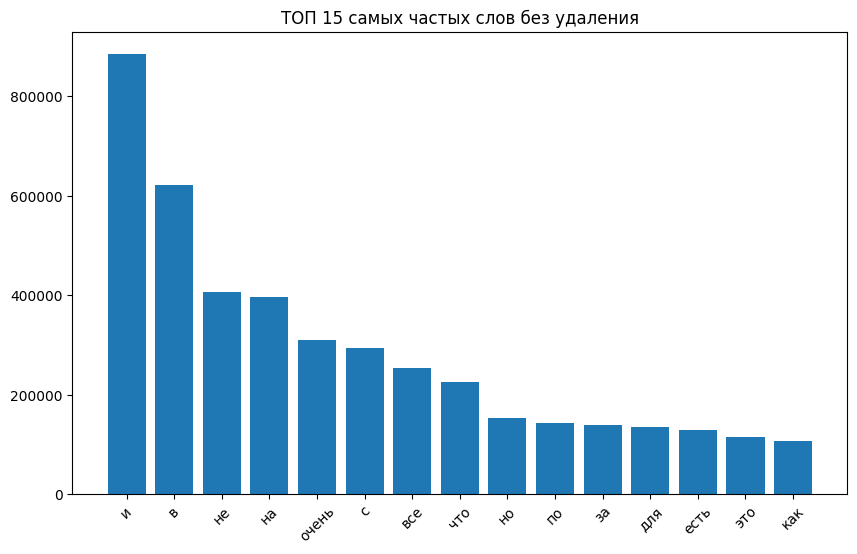

In [64]:
word_freq = Counter(all_words_flat)
most_common_words = word_freq.most_common(15)

plt.figure(figsize=(10, 6))
words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('ТОП 15 самых частых слов без удаления')
plt.show()

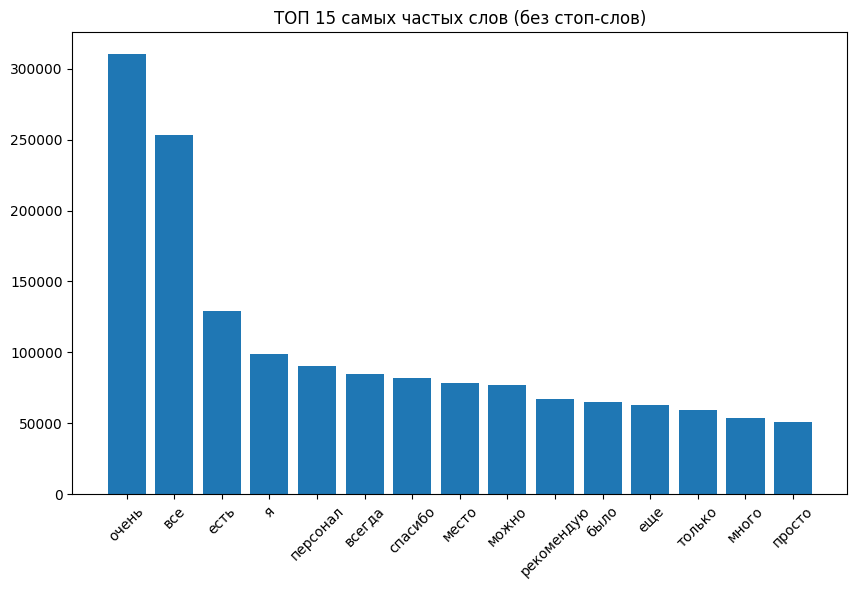

In [69]:
word_freq = Counter(all_words_cleaned_flat)
most_common_words = word_freq.most_common(15)

plt.figure(figsize=(10, 6))
words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('ТОП 15 самых частых слов (без стоп-слов)')
plt.show()

# Облако слов

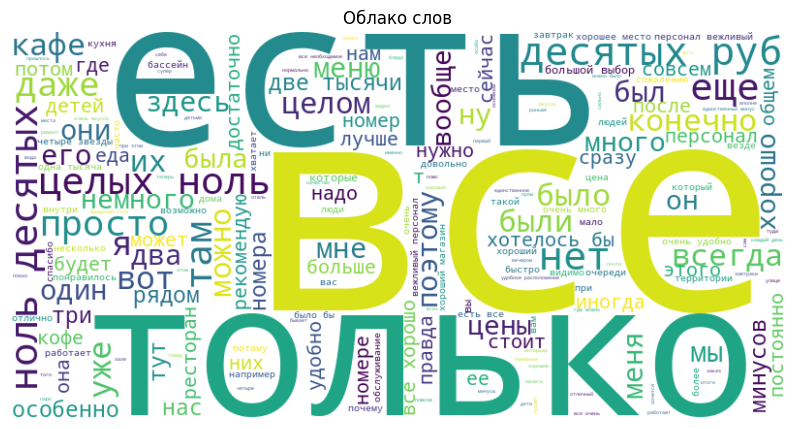

In [73]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words_cleaned_flat))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов')
plt.show()